---
title: Jolly-Seber
description: Estimating survival and abundance with Numpyro
author:
  name: Philip T. Patton
  affiliation:
    - Marine Mammal Research Program
    - Hawaiʻi Institute of Marine Biology
date: today
bibliography: refs.bib
jupyter: python3
execute:
  cache: true
---

Jolly-Seber models are a form of open-population capture-recapture models that estimate survival and abundance. They do so by estimating recruitment, broadly defined, at every time step. Contrast this with Cormack-Jolly-Seber models, which ignore recruitment to focus on just estimating survival.

There are many parameterizations of the Jolly-Seber model. For example, the Jolly-Seber model can be conceived of as a multi-state model with three states: not yet entered, alive, and dead [@kery2011] (@fig-diagram). Those who have not yet entered, $z_{i,t}=0$, can be recruited into the population, e.g., be born or immigrate into it, thus having $z_{i, t+1}=1$. These individuals may be captured with probability $p$. Then, these individuals might die or immigrate out of the population, thus having $z_{i, t+1}=2$. Such individuals can never re-enter the population.

This multi-state version of the Jolly-Seber is essentially the same as the restricted occupancy parameterization [@royle2008, chapter 10]. As such, the $\gamma$ parameter is a nuisance parameter with no biological meaning [@kery2011] (@fig-diagram). It represents "removal entry probabilities" [@kery2011], i.e., the probability that the individual is removed from the superpopulation at time $t$, which contains $M$ individuals. As such, $\gamma$ tends to grow over time because $M$ is fixed across all periods. In this case, $M$ refers to the size of the augmented dataset, meaning that, as in the [closed capture-recapture notebook](pymc-closed-cmr.qmd), we will be augmenting the capture histories with all-zero histories.

```{dot}
//| fig-cap: "Jolly-Seber multistate model: recruitment (γ), survival (φ), detection (p)"
//| label: fig-diagram

digraph js_multistate {
    rankdir=LR;
    node [shape=circle, style=filled, fontsize=11];

    subgraph cluster_t {
        label="Time t";
        style=rounded;
        N1 [label="Not yet\nentered\nz=0", fillcolor="#e8f4f8"];
        A1 [label="Alive\nz=1", fillcolor="#7eb6d4"];
        D1 [label="Dead\nz=2", fillcolor="#ef5350"];
    }

    subgraph cluster_t1 {
        label="Time t+1";
        style=rounded;
        N2 [label="Not yet\nentered\nz=0", fillcolor="#e8f4f8"];
        A2 [label="Alive\nz=1", fillcolor="#7eb6d4"];
        D2 [label="Dead\nz=2", fillcolor="#ed6c69ff"];
    }

    // Transition probabilities matching your matrix
    N1 -> N2 [label="1-γ"];
    N1 -> A2 [label="γ"];

    A1 -> A2 [label="φ"];
    A1 -> D2 [label="1-φ"];

    D1 -> D2 [label="1"];

    // Observation process
    obs [label="yₜ ~ Bernoulli(p·𝟙[z=1])", shape=box,
         style="rounded,filled", fillcolor="#c5f6c7ff"];
    A2 -> obs [style=dashed, color="#1976d2"];
}
```

In this notebook, I will primarily analyze simulated data. This is helpful because, as we will see, these models are sensitive to priors on $\gamma$. The simulation code is a direct translation of the code from [@kery2011, chapter 10], although I've vectorized the operations and leveraged some NumPy tricks, like `accummulate()`.

In [11]:
%config InlineBackend.figure_format = 'retina'

import numpyro
numpyro.set_host_device_count(4)

from jax import random
from jax.scipy.special import expit
from numpyro.contrib.control_flow import scan
from numpyro.infer import NUTS, MCMC, Predictive
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import seaborn as sns

# plotting defaults
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
sns.set_palette("tab10")

# hyperparameters
RANDOM_SEED = 1792
MAX_ABUNDANCE = 500 # size of augmented dipper dataset

# mcmc hyperparameters
CHAIN_COUNT = 4
WARMUP_COUNT = 500
SAMPLE_COUNT = 1000

# simulation hyperparameters
OCCASION_COUNT = 7
SUPERPOPULATION_SIZE = 400
PHI_LOW = 0.6
PHI_HIGH = 0.8
INITIAL_PI = 0.34
RECAPTURE_RATE = 0.5
M = 1000

# make the labels on arviz plots nicer
labeller = az.labels.MapLabeller(
    var_name_map={"psi": r"$\psi$", 'gamma':  r"$\gamma$", 'alpha': r'$\alpha$',
                  'epsilon': r"$\epsilon$", 'p':  r"$p$" , 'beta': r'$\beta$',
                  'phi': r'$\phi$', 'alpha_t': r'$\alpha_t$',}
)

def augment_history(history):
    '''Augments a capture histories with all zero histories'''
    number_encountered, occasion_count = history.shape
    number_to_augment = MAX_ABUNDANCE - number_encountered
    all_zero_histories = np.zeros((number_to_augment, occasion_count))
    y_augmented = np.vstack([history, all_zero_histories])
    return y_augmented.astype(np.int32)

def load_dipper_data():
    '''Loads and augments the classic dipper dataset'''
    dipper = np.loadtxt('dipper.csv', delimiter=',').astype(int)
    y_augmented = augment_history(dipper)

    return y_augmented

def sim_js():
    """Simulation code ported from Kery and Schaub (2012), Chapter 10"""

    rng = np.random.default_rng(RANDOM_SEED)
    interval_count = OCCASION_COUNT - 1

    # simulate entry into the population
    pi_rest = (1 - INITIAL_PI) / interval_count
    pi = np.concatenate([[INITIAL_PI], np.full(interval_count, pi_rest)])

    # which occasion did the animal enter in?
    entry_matrix = rng.multinomial(n=1, pvals=pi, size=SUPERPOPULATION_SIZE)
    entry_occasion = entry_matrix.nonzero()[1]
    _, entrant_count = np.unique(entry_occasion, return_counts=True)

    # zero if the animal has not yet entered and one after it enters
    entry_trajectory = np.maximum.accumulate(entry_matrix, axis=1)

    # flip coins for survival between occasions
    apparent_survival = rng.uniform(PHI_LOW, PHI_HIGH, interval_count)
    survival_draws = rng.binomial(
        1, apparent_survival, (SUPERPOPULATION_SIZE, interval_count)
    )

    # add column such that survival between t and t+1 implies alive at t+1
    survival_draws = np.column_stack([np.ones(SUPERPOPULATION_SIZE), survival_draws])

    # ensure that the animal survives until it enters
    is_yet_to_enter = np.arange(OCCASION_COUNT) <= entry_occasion[:, None]
    survival_draws[is_yet_to_enter] = 1

    # once the survival_draws flips to zero the remaining row stays 0
    survival_trajectory = np.cumprod(survival_draws, axis=1)

    # animal has entered AND is still alive
    state = entry_trajectory * survival_trajectory

    # binary matrix of random possible recaptures
    capture = rng.binomial(
        1, RECAPTURE_RATE, (SUPERPOPULATION_SIZE, OCCASION_COUNT)
    )

    # remove the non-detected individuals
    capture_history = state * capture
    was_captured = capture_history.sum(axis=1) > 0
    capture_history = capture_history[was_captured]

    # augment the history with nz animals
    n, _ = capture_history.shape
    nz = M - n
    all_zero_history = np.zeros((nz, OCCASION_COUNT))
    capture_history = np.vstack([capture_history, all_zero_history]).astype(int)

    # return a dict with relevant summary stats
    N_t = state.sum(axis=0)
    return {
        'capture_history': capture_history,
        'N_t': N_t,
        'B': entrant_count,
        'apparent_survival': apparent_survival
    }

# Model definition

The model is very similar to the one described in the [dynamic occupancy notebook](numpyro-occ.qmd). The primary difference is that the probabilities for the $z_{i, j}$ states are encoded via the transition probability matrix (@tbl-tpm).

: Transition probability matrix in the NumPyro model  {#tbl-tpm}

| From ↓ / To → | Not yet entered ($z=0$) | Alive ($z=1$) | Dead ($z=2$) |
|:--------------|----------------------:|--------------:|-------------:|
| **Not yet entered** ($z=0$) | $1 - \gamma_t$ | $\gamma_t$ | $0$ |
| **Alive** ($z=1$) | $0$ | $\phi$ | $1 - \phi$ |
| **Dead** ($z=2$) | $0$ | $0$ | $1$ |

Parameterizing the model this way is the easiest way in NumPyro to encode the restriction that dead animals cannot re-enter the population. To match the data-generating process, I allow $\gamma$ to time vary while keeping $\phi$ and $p$ constant across animals and occasions.

The model also shows how to compute derived quantities with NumPyro. Here, I generate estimates for the entry probabilities, $\pi,$ and the overall inclusion probability, $\psi$. This helps compare with the data generating process in `sim_js()`, as well as compare with the Schwarz-Arnason (POPAN) formulation of the model.

One principle difference and the multi-state version described in [@kery2011,chapter 10] is that we do not include a dummy occasion of all zeros. This is because we can initialize the $z_{i,0}$ to be $0$ for all individuals, (see `z0` below). Then, we begin the scan starting at the first occasion in our capture history. As such, we estimate transition from this initial state to the first occasion in our capture history. Contrast this with the [dynamic occupancy notebook](numpyro-occ.qmd), where we begin the scan at the second season in the detection data.

In [12]:
def js_prior1(capture_history):

    super_size, occasion_count = capture_history.shape

    p = numpyro.sample('p', dist.Uniform(0, 1))

    with numpyro.plate('occasions', occasion_count):
        gamma = numpyro.sample('gamma', dist.Uniform(0, 1))

    with numpyro.plate('intervals', occasion_count - 1):
        phi = numpyro.sample('phi', dist.Uniform(0, 1))
    phi_vec = jnp.concatenate([jnp.array([1]), phi])

    def transition_and_capture(carry, y_current):

        z_previous, t = carry

        # transition probability matrix
        trans_probs = jnp.array([
            [1 - gamma[t], gamma[t],     0.0],  # From not yet entered
            [         0.0,      phi_vec[t], 1 - phi_vec[t]],  # From alive
            [         0.0,      0.0,     1.0]   # From dead
        ])

        with numpyro.plate("animals", super_size, dim=-1):

            # transition probabilities depend on current state
            mu_z_current = trans_probs[z_previous]
            z_current = numpyro.sample(
                "state",
                dist.Categorical(dist.util.clamp_probs(mu_z_current)),
                infer={"enumerate": "parallel"}
            )

            mu_y_current = jnp.where(z_current == 1, p, 0.0)
            numpyro.sample(
                "obs",
                dist.Bernoulli(dist.util.clamp_probs(mu_y_current)),
                obs=y_current
            )

        return (z_current, t + 1), None

    # start everyone in the not yet entered state
    state_init = jnp.zeros(super_size, dtype=jnp.int32)
    scan(
        transition_and_capture,
        (state_init, 0),
         jnp.swapaxes(capture_history, 0, 1)
    )

    # calculate derived parameters
    qgamma = 1 - gamma

    # psi is the overall inclusion probability
    cumulative_qgamma = jnp.concatenate([
        jnp.array([1.0]),
        jnp.cumprod(qgamma[:-1])
    ])
    cprob = gamma * cumulative_qgamma
    psi = jnp.sum(cprob)
    numpyro.deterministic('psi', psi)

    # pi for each occasion
    numpyro.deterministic('pi', cprob / psi )

The downside of coding the model this way in BUGS is that it takes forever to sample. For example, it took [@kery2011] 32 minutes to fit this model to these data with BUGS. In NumPyro, however, we totally sidestep this issue with state enumeration. In fact, this version only takes 11 seconds to sample!

In [13]:
sim_results = sim_js()
capture_histories = sim_results['capture_history']

rng_key = random.PRNGKey(RANDOM_SEED)

# specify which sampler you want to use
nuts_kernel = NUTS(js_prior1)

# configure the MCMC run
mcmc = MCMC(nuts_kernel, num_warmup=WARMUP_COUNT, num_samples=SAMPLE_COUNT,
            num_chains=1)

# run the MCMC then inspect the output
mcmc.run(rng_key, capture_histories)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:22<00:00, 66.16it/s, 15 steps of size 2.29e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      0.15      0.02      0.15      0.11      0.19    683.35      1.00
  gamma[1]      0.07      0.02      0.07      0.03      0.11   1099.65      1.00
  gamma[2]      0.04      0.02      0.04      0.01      0.07    518.80      1.00
  gamma[3]      0.11      0.03      0.11      0.07      0.15    807.91      1.00
  gamma[4]      0.05      0.03      0.05      0.01      0.09   1144.32      1.00
  gamma[5]      0.08      0.03      0.08      0.04      0.13    702.32      1.00
  gamma[6]      0.09      0.03      0.08      0.03      0.14    481.52      1.00
         p      0.38      0.04      0.38      0.33      0.45    657.17      1.00
    phi[0]      0.55      0.10      0.55      0.39      0.72    871.52      1.00
    phi[1]      0.73      0.11      0.72      0.58      0.94    469.84      1.00
    phi[2]      0.66      0.10      0.66      0.51      0.82    621.90      1.00
    phi[3]      0.71      0

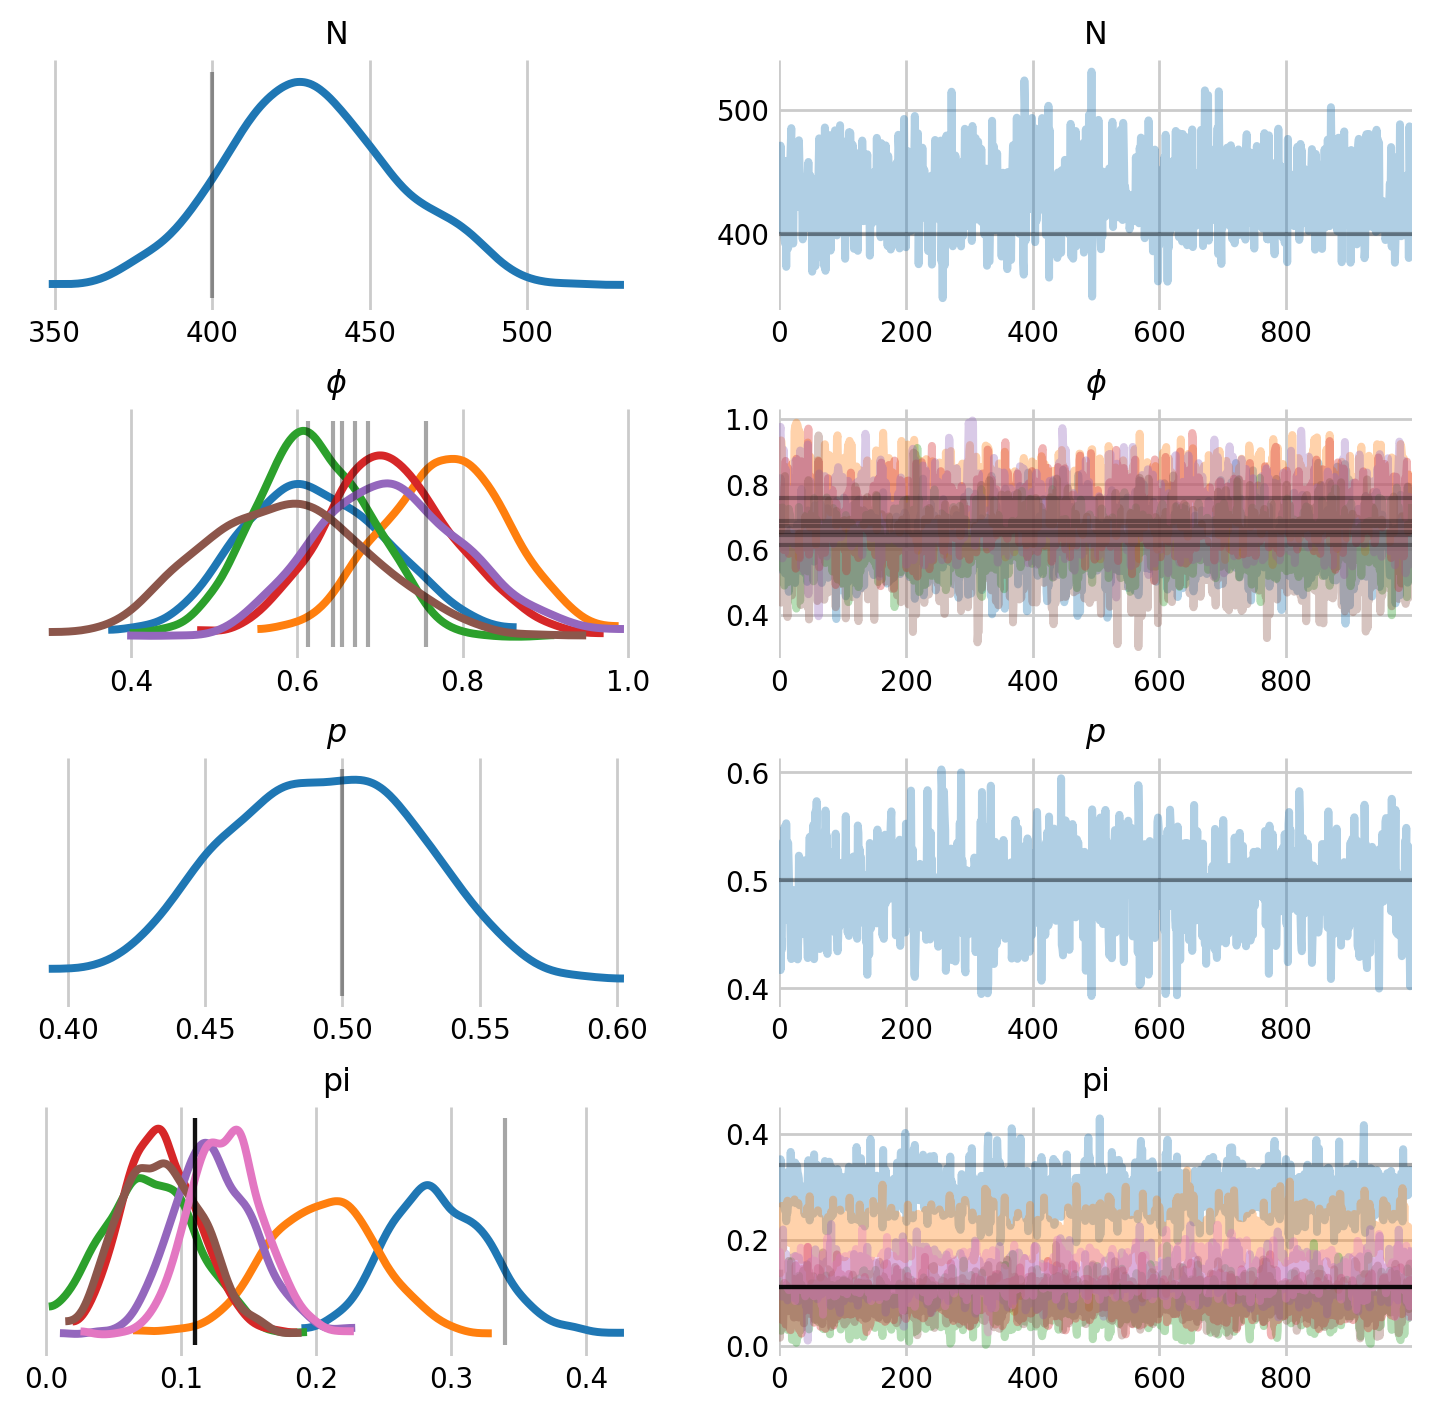

In [10]:
#| fig-cap: Traceplots for multi-state Jolly-Seber model
#| label: fig-trace-ms

# create the inference data object for arviz
samples = mcmc.get_samples(group_by_chain=True)
idata = az.from_dict(samples)

# simplest way to compute the superpopulation size
idata.posterior['N'] = idata.posterior['psi'] * M

pi_rest = (1 - INITIAL_PI) / (OCCASION_COUNT - 1)
pi = np.concat([[INITIAL_PI], np.full(OCCASION_COUNT - 1, pi_rest)])
apparent_survival = sim_results['apparent_survival']

# generate traceplots for parameters
az.plot_trace(
    idata,
    figsize=(8,8),
    var_names=['N', 'phi', 'p', 'pi'],
    labeller=labeller,
    lines=[("phi", {}, [apparent_survival]), ("p", {}, [RECAPTURE_RATE]),
           ("pi", {}, pi), ("N", {}, [SUPERPOPULATION_SIZE])],
)
plt.subplots_adjust(hspace=0.4)

The model appears to recover the parameters well. While we generated abundance estimates with the `psi` parameter above, we can also generate them with the posterior predictive distribution.

In [ ]:
#| fig-cap: Posterior distribution of $N$ with multi-state Jolly-Seber model.
#| label: fig-n-prior1

def sample_z(model, posterior_samples, capture_history):
    '''Samples the posterior predictive distribution for z given the histories'''

    # initialize the posterior predictive distribution
    predictive = Predictive(
        model,
        posterior_samples=posterior_samples,
        return_sites=["state"]
    )

    # sample z
    rng_key = random.PRNGKey(RANDOM_SEED)
    latent_samples = predictive(rng_key, capture_history)
    return latent_samples["state"]

# generate the posterior predictive distribution for N
samples = mcmc.get_samples()
z = sample_z(js_prior1, samples, capture_histories)
ever_alive = z.max(axis=1) > 0
samples['N'] = ever_alive.sum(axis=1)

# create the plot
fig, ax = plt.subplots(figsize=(5, 4), sharey=True)

ax.hist(samples['N'], bins=20, fc='tab:cyan', ec='w', alpha=0.99)

ax.set_title(r'Posterior distribution of $N$')
ax.axvline(SUPERPOPULATION_SIZE, linestyle='--', color='tab:pink', label='Truth')
ax.axvline(np.median(samples['N']), linestyle='--', color='tab:purple', label='Median')

ax.legend()

plt.show()

# Prior sensitivity

The above plot shows one potential issue with this parameterization, and the restricted occupancy formulation, namely, that the abundance is sensitive to prior choice. In fact, the prior distribution on abundance is no longer $N \sim \mathrm{DiscreteUniform}(0, M)$. @royle2008 provide two alternative prior specifications for this model. I explore them both below.

## Schwarz-Arnason-esque prior

This version of the model is very similar to the Schwarz-Arnason parameterization described in [@royle2008]. We develop this model by placing a prior distribution on the entry probabilities, $\pi,$ and the inclusion probability, $\psi.$ We can use these values to compute the removal probabilities,
$$
\begin{align}
\gamma_0 &= \psi \pi_0 \\
\gamma_t &= \frac{\psi \pi_t}{\prod_{j=1}^{t-1}(1 - \gamma_j)}, \quad t = 1, \ldots, T
\end{align}
$$

One benefit of this approach is that it obviates the need to compute the derived quanitites. Moreover, it allows us to directly compare to the data generating processs.

In [ ]:
def js_prior2(capture_history):

    super_size, occasion_count = capture_history.shape

    with numpyro.plate('intervals', occasion_count - 1):
        phi = numpyro.sample('phi', dist.Uniform(0, 1))
    phi_vec = jnp.concatenate([jnp.array([1]), phi])

    p = numpyro.sample('p', dist.Uniform(0, 1))

    # parameterize the  entry probabilities in terms of pi and psi
    psi = numpyro.sample('psi', dist.Uniform(0, 1))
    pi = numpyro.sample('pi', dist.Dirichlet(jnp.ones(occasion_count)))

    # compute the removal probabilities as a function of psi and pi
    gamma = jnp.zeros(occasion_count)

    # the `vector.at[0].set(1)` notation is jax for `vector[0] = 1`
    gamma = gamma.at[0].set(psi * pi[0])
    for t in range(1, occasion_count):
        denominator = jnp.prod(1 - gamma[:t])
        gamma = gamma.at[t].set(psi * pi[t] / denominator)
    gamma = numpyro.deterministic('gamma', gamma)

    def transition_and_capture(carry, y_current):

        z_previous, t = carry

        trans_probs = jnp.array([
            [1 - gamma[t], gamma[t], 0.0],  # From not yet entered
            [0.0, phi, 1 - phi],            # From alive
            [0.0, 0.0, 1.0]                 # From dead
        ])

        with numpyro.plate("animals", super_size, dim=-1):

            mu_z_current = trans_probs[z_previous]
            z_current = numpyro.sample(
                "state",
                dist.Categorical(dist.util.clamp_probs(mu_z_current)),
                infer={"enumerate": "parallel"}
            )

            mu_y_current = jnp.where(z_current == 1, p, 0.0)
            numpyro.sample(
                "obs",
                dist.Bernoulli(dist.util.clamp_probs(mu_y_current)),
                obs=y_current
            )

        return (z_current, t + 1), None

    # start everyone in the not yet entered state
    state_init = jnp.zeros(super_size, dtype=jnp.int32)
    scan(
        transition_and_capture,
        (state_init, 0),
         jnp.swapaxes(capture_history, 0, 1)
    )

In [ ]:
# specify which sampler you want to use
nuts_kernel = NUTS(js_prior2)

# configure the MCMC run
mcmc = MCMC(nuts_kernel, num_warmup=WARMUP_COUNT, num_samples=SAMPLE_COUNT,
            num_chains=CHAIN_COUNT)

# run the MCMC then inspect the output
mcmc.run(rng_key, capture_histories)
mcmc.print_summary()

In [ ]:
#| fig-cap: Posterior distribution of $N$ with priors on $\pi$ and $\psi$
#| label: fig-n-prior2

# generate the posterior predictive distribution for N
samples = mcmc.get_samples()
z = sample_z(js_prior2, samples, capture_histories)
ever_alive = z.max(axis=1) > 0
samples['N'] = ever_alive.sum(axis=1)

# create the plot
fig, ax = plt.subplots(figsize=(5, 4), sharey=True)

ax.hist(samples['N'], bins=20, fc='tab:cyan', ec='w', alpha=0.99)

ax.set_title(r'Posterior distribution of $N$')
ax.axvline(SUPERPOPULATION_SIZE, linestyle='--', color='tab:pink', label='Truth')
ax.axvline(np.median(samples['N']), linestyle='--', color='tab:purple', label='Median')

ax.legend()

plt.show()

The resulting estimate of $N$ is much closer to the true superpopulation size than the original version with a uniform prior on $\gamma.$ One potential downside of this approach is that it requires some familiarity with the relationships between the Schwarz-Arnason parameterizations and the restricted occupancy parameterizations of the Jolly-Seber model.

## Beta prior

An easier alternative is to approximate the above prior. As such, we try to approximate the situation where half of all animal in $M$ are recruited, and each of these is equally likely to be recruited during $t$. So when $T=7$, we hope that $1/14$ of all individuals are allocated to each time step. To do so, we set a Beta prior, $\gamma_t \sim \mathrm{Beta}(a_t, b_t),$ where $a_t = S/(14-(t-1))$ and $b_t = S - a_t.$ @royle2008 recommend setting $S=1.5$.

In [ ]:
def js_prior3(capture_history):

    super_size, occasion_count = capture_history.shape

    phi = numpyro.sample('phi', dist.Uniform(0, 1))
    p = numpyro.sample('p', dist.Uniform(0, 1))

    # approximate the situation where half of all individuals are allocated
    # to each time step
    S = 1.5
    t = np.arange(1, occasion_count + 1)
    C = occasion_count * 2
    a_t = S / (C - (t - 1))
    b_t = S - a_t
    with numpyro.plate('occasions', occasion_count):
        gamma = numpyro.sample('gamma', dist.Beta(a_t, b_t))

    def transition_and_capture(carry, y_current):

        z_previous, t = carry

        trans_probs = jnp.array([
            [1 - gamma[t], gamma[t], 0.0],  # From not yet entered
            [0.0, phi, 1 - phi],            # From alive
            [0.0, 0.0, 1.0]                 # From dead
        ])

        with numpyro.plate("animals", super_size, dim=-1):

            mu_z_current = trans_probs[z_previous]
            z_current = numpyro.sample(
                "state",
                dist.Categorical(dist.util.clamp_probs(mu_z_current)),
                infer={"enumerate": "parallel"}
            )

            mu_y_current = jnp.where(z_current == 1, p, 0.0)
            numpyro.sample(
                "obs",
                dist.Bernoulli(dist.util.clamp_probs(mu_y_current)),
                obs=y_current
            )

        return (z_current, t + 1), None

    # start everyone in the not yet entered state
    state_init = jnp.zeros(super_size, dtype=jnp.int32)
    scan(
        transition_and_capture,
        (state_init, 0),
         jnp.swapaxes(capture_history, 0, 1)
    )

In [ ]:
# specify which sampler you want to use
nuts_kernel = NUTS(js_prior3)

# configure the MCMC run
mcmc = MCMC(nuts_kernel, num_warmup=WARMUP_COUNT, num_samples=SAMPLE_COUNT,
            num_chains=CHAIN_COUNT)

# run the MCMC then inspect the output
mcmc.run(rng_key, capture_histories)
mcmc.print_summary()

In [ ]:
#| fig-cap: Posterior distribution of $N$ with approximate prior on $\gamma$
#| label: fig-n-prior3

# generate the posterior predictive distribution for N
samples = mcmc.get_samples()
z = sample_z(js_prior3, samples, capture_histories)
ever_alive = z.max(axis=1) > 0
samples['N'] = ever_alive.sum(axis=1)

# create the plot
fig, ax = plt.subplots(figsize=(5, 4), sharey=True)

ax.hist(samples['N'], bins=20, fc='tab:cyan', ec='w', alpha=0.99)

ax.set_title(r'Posterior distribution of $N$')
ax.axvline(SUPERPOPULATION_SIZE, linestyle='--', color='tab:pink', label='Truth')
ax.axvline(np.median(samples['N']), linestyle='--', color='tab:purple', label='Median')

ax.legend()

plt.show()

Once again these priors do a better job of estimating $N$ than the Uniform prior.

# Dipper dataset

Finally, I turn to the ubiquitous dipper data, analyzed in [@royle2008,chapter 10]. To match their analysis, I fit the full version of the model, where every parameter is time varying, i.e., $p(t) \phi(t) \pi(t).$ This model is overparameterized, meaning that not all the parameters are estimable. Following [@royle2008], I skirt this issue by assuming that $p_{0}=p_{T}=1$.Here, I use the Schwarz-Arnason-esque parameterization.

The primary difference from the above models is the need to index both `phi` and `p`. Recall that `gamma[0]` controls entry into the superpopulation from the initial state to the first iteration of the scan. As such, `gamma[1]` controls entry into the population at the second occasion, and `phi[0]` controls survival from the first occasion to the second occasion. As such, the transition probability matrix contains `gamma[t]` and `phi[t - 1]`.

In [ ]:
def js_full(capture_history):

    super_size, occasion_count = capture_history.shape
    interval_count = occasion_count - 1
    p_count = interval_count - 1

    # parameterize the  entry probabilities in terms of pi and psi
    psi = numpyro.sample('psi', dist.Uniform(0, 1))
    pi = numpyro.sample('pi', dist.Dirichlet(jnp.ones(occasion_count)))

    # compute the removal probabilities as a function of psi and pi
    gamma = jnp.zeros(occasion_count)

    # the `vector.at[0].set(1)` notation is jax for `vector[0] = 1`
    gamma = gamma.at[0].set(psi * pi[0])
    for t in range(1, occasion_count):
        denominator = jnp.prod(1 - gamma[:t])
        gamma = gamma.at[t].set(psi * pi[t] / denominator)
    gamma = numpyro.deterministic('gamma', gamma)

    with numpyro.plate('intervals', interval_count):
        phi = numpyro.sample('phi', dist.Uniform(0, 1))

    with numpyro.plate('ps', p_count):
        p_estimable = numpyro.sample('p_estimable', dist.Uniform(0, 1))

    # fix the detection probability on the first couple of occasions to 1
    p = jnp.concatenate([jnp.array([1]), p_estimable, jnp.array([1])])

    def transition_and_capture(carry, y_current):

        z_previous, t = carry

        trans_probs = jnp.array([
            [1 - gamma[t],   gamma[t],            0.0], # From not yet entered
            [         0.0, phi[t - 1], 1 - phi[t - 1]], # From alive
            [         0.0,        0.0,            1.0]  # From dead
        ])

        with numpyro.plate("animals", super_size, dim=-1):

            mu_z_current = trans_probs[z_previous]
            z_current = numpyro.sample(
                "state",
                dist.Categorical(dist.util.clamp_probs(mu_z_current)),
                infer={"enumerate": "parallel"}
            )

            mu_y_current = jnp.where(z_current == 1, p[t], 0.0)
            numpyro.sample(
                "obs",
                dist.Bernoulli(dist.util.clamp_probs(mu_y_current)),
                obs=y_current
            )

        return (z_current, t + 1), None

    state_init = jnp.zeros(super_size, dtype=jnp.int32)
    scan(transition_and_capture, (state_init, 0),
         jnp.swapaxes(capture_history, 0, 1))

In [ ]:
dipper = load_dipper_data()

# specify which sampler you want to use
nuts_kernel = NUTS(js_full)

# configure the MCMC run
mcmc = MCMC(nuts_kernel, num_warmup=WARMUP_COUNT, num_samples=SAMPLE_COUNT,
            num_chains=CHAIN_COUNT)

# run the MCMC then inspect the output
mcmc.run(rng_key, dipper)
mcmc.print_summary()

In [ ]:
#| fig-cap: Traceplots for full model of the dipper data.
#| label: fig-trace-full

samples = mcmc.get_samples(group_by_chain=True)
idata = az.from_dict(samples)
idata.posterior['N'] = idata.posterior['psi'] * MAX_ABUNDANCE
idata.posterior['p'] = idata.posterior['p_estimable']

# posterior means from table 10.1 in Royle and Dorazio (2008)
phi_royle = [0.741, 0.454, 0.481, 0.628, 0.602, 0.526]
p_royle = [0.618, 0.863, 0.876, 0.873, 0.902]
pi_royle = [0.068, 0.263, 0.135, 0.146, 0.132, 0.145, 0.111]
N_royle = 326.5

# generate traceplots for parameters
ax = az.plot_trace(
    idata,
    figsize=(8,8),
    var_names=['N', 'phi', 'p', 'pi'],
    labeller=labeller,
    lines=[("phi", {}, phi_royle), ("p", {}, p_royle),
           ("pi", {}, pi_royle), ("N", {}, N_royle)],
)
plt.subplots_adjust(hspace=0.4)
row_count, _ = ax.shape
[ax[i, 0].grid(False) for i in range(row_count)]

As we can see, the parameter estimates are very similar to that of [@royle2008]. We can also plot survival over time, to compare with the [PyMC Jolly-Seber notebook](pymc-jssa.qmd).

In [ ]:
samples = mcmc.get_samples(group_by_chain=False)

fig, ax = plt.subplots(figsize=(6,4))

t = np.arange(1981, 1987)

phi_samples = samples['phi']
phi_median = np.median(phi_samples, axis=0)

ax.plot(t, phi_median, linestyle='dotted', color='lightgray', linewidth=2)
ax.violinplot(phi_samples, t, showmedians=True, showextrema=False)

ax.set_ylim((0,1))

ax.set_ylabel(r'Apparent survival $\phi$')
ax.set_title(r'Dipper JSSA')

plt.show()

# Conclusion

Here, I demonstrated how to estimate survival and abundance with Jolly-Seber models in NumPyro. To do so, I fit the model with the multi-state parameterization described in @kery2011. This is virtually identical to the restricted occupancy parameterization of the model [@royle2008]. The primary difference is also its downfall in BUGS, namely, its reliance on the Categorical distribution. As with the other NumPyro notebooks in this series, I skirted this problem with NumPyro's automated marginalization (enumeration). As a result, a model that takes 32 minutes to fit in BUGS takes 11 seconds to fit here.

Of course, it would be even faster to fit the marginalized version of the model described in the [PyMC Jolly-Seber notebook](pymc-jssa.qmd). Nevertheless, it is oftentimes more intuitive to specify the model in terms of the generating process, i.e., the $z_{i,t}$ state. Moreover, doing so facilitates fitting models with individual variation. As such, NumPyro's automated enumeration provides the best of both worlds.

I focused on the multi-state parameterization because I was unable to find a way to fit the restricted occupancy or Schwarz-Arnason versions of the model in NumPyro. Both versions rely on accumulated $z_{i,t}$ state over time. As far as I can tell, the NumPyro enumeration procedure prohibits this. Users who are interested might open an issue with the NumPyro team.